# Predict Customer Churn

- Understanding a problem and final goal
- Data collection
- Data preparation and preprocessing
- Modeling and testing
- Model deployment and monitoring

In [26]:
# Python version
import sys
print('Python: {}'.format(sys.version))
# scipy
import scipy
print('scipy: {}'.format(scipy.__version__))
# numpy
import numpy
print('numpy: {}'.format(numpy.__version__))
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# pandas
import pandas
print('pandas: {}'.format(pandas.__version__))
# scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))

Python: 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 21:52:21) 
[GCC 7.3.0]
scipy: 1.3.1
numpy: 1.17.2
matplotlib: 3.1.1
pandas: 0.25.1
sklearn: 0.22.2


In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
from scipy.stats import norm, skew
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline


## Warnings and other tools
import itertools
import warnings
warnings.filterwarnings("ignore")

## Load

In [6]:
dataset = pd.read_csv('../Churn_Prediction/client_dataset.csv', delimiter=";")
dataset.head(10)

idClient  Score CountryLocation  Gender  Age  Tenure  Games Balance  \
0         1    619          France  Female   42       2           0.00   
1         2    608           Spain  Female   41       1       83807.86   
2         3    502          France  Female   42       8      159660.80   
3         4    699          France  Female   39       1           0.00   
4         5    850           Spain  Female   43       2      125510.82   
5         6    645           Spain    Male   44       8      113755.78   
6         7    822          France    Male   50       7           0.00   
7         8    376         Germany  Female   29       4      115046.74   
8         9    501          France    Male   44       4      142051.07   
9        10    684          France    Male   27       2      134603.88   

   NumOfProducts  HasPremiumAccess  IsActiveMember  Cumulative score  Churn  
0              1                 1               1         101348.88      1  
1              1                 0               1         112542.58      0  
2              3                 1               0         113931.57      1  
3              2                 0               0          93826.63      0  
4              1                 1               1          79084.10      0  
5              2                 1               0         149756.71      1  
6              2                 1               1          10062.80      0  
7              4                 1               0         119346.88      1  
8              2                 0               1          74940.50      0  
9              1                 1               1          71725.73      0

## Missing values

In [7]:
dataset.columns

Index(['idClient', 'Score', 'CountryLocation', 'Gender', 'Age', 'Tenure',
       'Games Balance', 'NumOfProducts', 'HasPremiumAccess', 'IsActiveMember',
       'Cumulative score', 'Churn'],
      dtype='object')

In [8]:
# Create a function to detect and shows missing values
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

In [9]:
missing_zero_values_table(dataset)

Your selected dataframe has 12 columns and 10000 Rows.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Zero Values, Missing Values, % of Total Values, Total Zero Missing Values, % Total Zero Missing Values, Data Type]
Index: []

## EDA

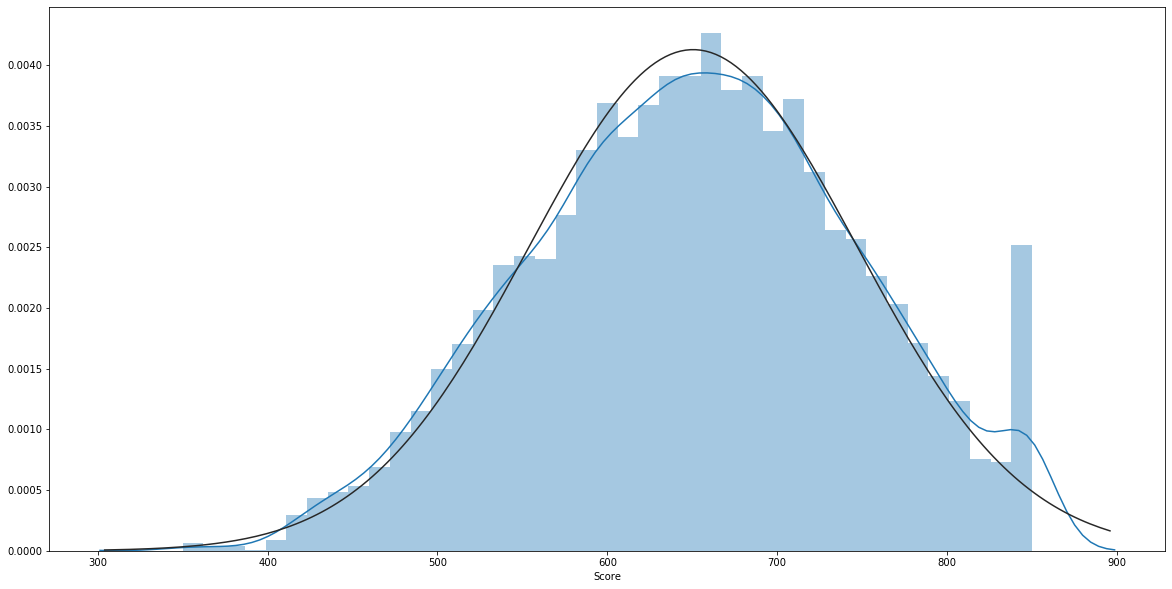

In [11]:
# Plot the distribution
plt.figure(figsize= [20.0, 10.0])
sns.distplot(dataset['Score'], fit=norm)

In [15]:
dataset['Score'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: Score, dtype: float64

In [17]:
print("Score variable has {0} total observations and {1} are unique only.".format(dataset['Score'].count(),dataset['Score'].nunique()))

Score variable has 10000 total observations and 460 are unique only.


In [18]:
pd.qcut(dataset['Score'], q=4)

0         (584.0, 652.0]
1         (584.0, 652.0]
2       (349.999, 584.0]
3         (652.0, 718.0]
4         (718.0, 850.0]
              ...       
9995      (718.0, 850.0]
9996    (349.999, 584.0]
9997      (652.0, 718.0]
9998      (718.0, 850.0]
9999      (718.0, 850.0]
Name: Score, Length: 10000, dtype: category
Categories (4, interval[float64]): [(349.999, 584.0] < (584.0, 652.0] < (652.0, 718.0] < (718.0, 850.0]]

In [20]:
dataset['ScoreGroup'] = pd.cut(dataset['Score'], 4, labels=['BRONCE', 'SILVER', 'GOLD', 'PLATINUM'])

In [21]:
pd.crosstab(dataset['ScoreGroup'], dataset['Churn'])

Churn          0    1
ScoreGroup           
BRONCE       265   92
SILVER      2136  573
GOLD        3754  910
PLATINUM    1808  462

In [24]:
pd.crosstab(index=dataset["ScoreGroup"],
                        columns=dataset["Churn"], margins=True)

Churn          0     1    All
ScoreGroup                   
BRONCE       265    92    357
SILVER      2136   573   2709
GOLD        3754   910   4664
PLATINUM    1808   462   2270
All         7963  2037  10000

In [25]:
pd.crosstab(index=dataset["CountryLocation"],
                        columns=dataset["Churn"], margins=True)

Churn               0     1    All
CountryLocation                   
France           4204   810   5014
Germany          1695   814   2509
Spain            2064   413   2477
All              7963  2037  10000

In [27]:
pd.crosstab(index=dataset["Gender"],
                        columns=dataset["Churn"], margins=True)

Churn      0     1    All
Gender                   
Female  3404  1139   4543
Male    4559   898   5457
All     7963  2037  10000

In [28]:
# Realizar la binarización de las variables categóricas
# gender = pd.get_dummies(dataset['Gender'])
# dataset = pd.concat([dataset, gender], axis=1)

Female  Male
0          1     0
1          1     0
2          1     0
3          1     0
4          1     0
...      ...   ...
9995       0     1
9996       0     1
9997       1     0
9998       0     1
9999       1     0

[10000 rows x 2 columns]

In [29]:
# Convert categorical variable to binary variable where female 1 and male 0
dataset['Gender'] = dataset['Gender'].map( {'Female': 1, 'Male': 0} ).astype(int)

In [30]:
dataset.head(10)

idClient  Score CountryLocation  Gender  Age  Tenure  Games Balance  \
0         1    619          France       1   42       2           0.00   
1         2    608           Spain       1   41       1       83807.86   
2         3    502          France       1   42       8      159660.80   
3         4    699          France       1   39       1           0.00   
4         5    850           Spain       1   43       2      125510.82   
5         6    645           Spain       0   44       8      113755.78   
6         7    822          France       0   50       7           0.00   
7         8    376         Germany       1   29       4      115046.74   
8         9    501          France       0   44       4      142051.07   
9        10    684          France       0   27       2      134603.88   

   NumOfProducts  HasPremiumAccess  IsActiveMember  Cumulative score  Churn  \
0              1                 1               1         101348.88      1   
1              1                 0               1         112542.58      0   
2              3                 1               0         113931.57      1   
3              2                 0               0          93826.63      0   
4              1                 1               1          79084.10      0   
5              2                 1               0         149756.71      1   
6              2                 1               1          10062.80      0   
7              4                 1               0         119346.88      1   
8              2                 0               1          74940.50      0   
9              1                 1               1          71725.73      0   

  ScoreGroup  
0       GOLD  
1       GOLD  
2     SILVER  
3       GOLD  
4   PLATINUM  
5       GOLD  
6   PLATINUM  
7     BRONCE  
8     SILVER  
9       GOLD

`Age`

In [31]:
print("Age variable has {0} total observations and {1} are unique only.".format(dataset['Age'].count(),dataset['Age'].nunique()))

Age variable has 10000 total observations and 70 are unique only.


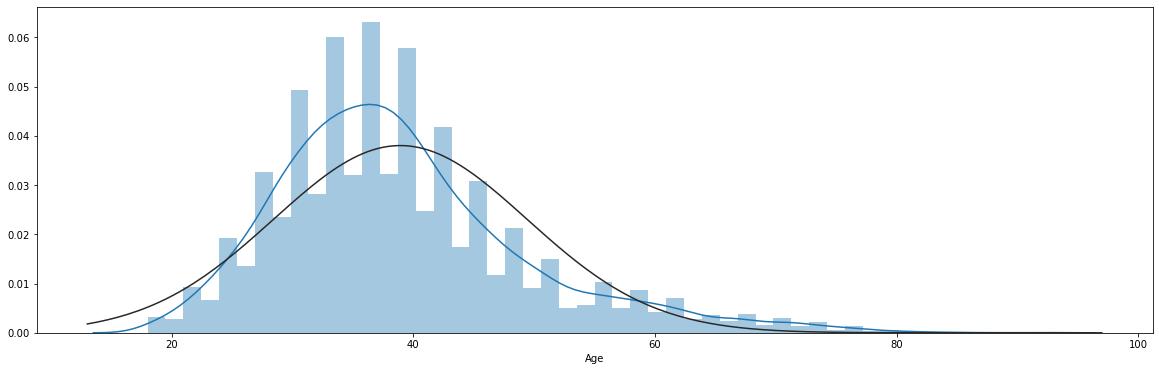

In [32]:
# Plot the distribution
plt.figure(figsize= [20.0, 6.0])
sns.distplot(dataset['Age'], fit=norm)

In [33]:
dataset['Age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

In [35]:
# grouped in 6 bins
bins = [-np.inf, 24, 35, 44, 54, 64, np.inf]
labels = ['Teenager', 'Student', 'Young Adult', 'Adult', 'Mid-Senior', 'Senior']
dataset['AgeGroup'] = pd.cut(dataset["Age"], bins, labels = labels)

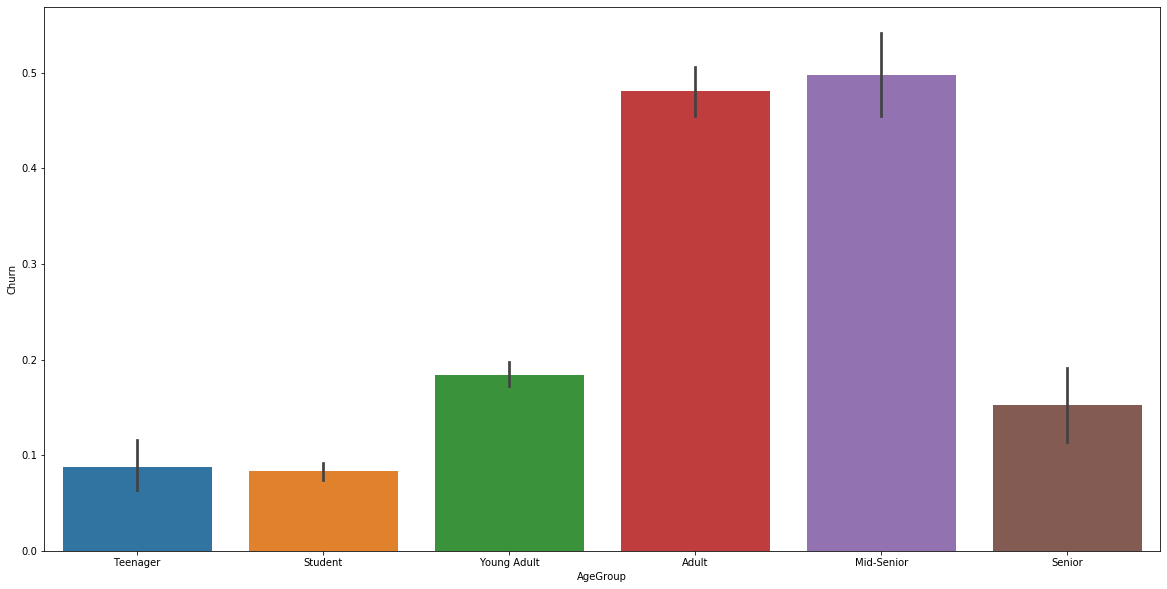

In [36]:
# Plot the distribution AgeGroup and Churn
plt.figure(figsize= [20.0, 10.0])
sns.barplot(x="AgeGroup", y="Churn", data=dataset)
plt.show()

In [37]:
pd.crosstab(index=dataset["AgeGroup"],
                        columns=dataset["Churn"], margins=True)

Churn           0     1    All
AgeGroup                      
Teenager      417    40    457
Student      3389   307   3696
Young Adult  2861   646   3507
Adult         756   702   1458
Mid-Senior    301   299    600
Senior        239    43    282
All          7963  2037  10000

In [38]:
print("Games Balance variable has {0} total observations and {1} are unique only.".format(dataset['Games Balance'].count(),dataset['Games Balance'].nunique()))

Games Balance variable has 10000 total observations and 6382 are unique only.


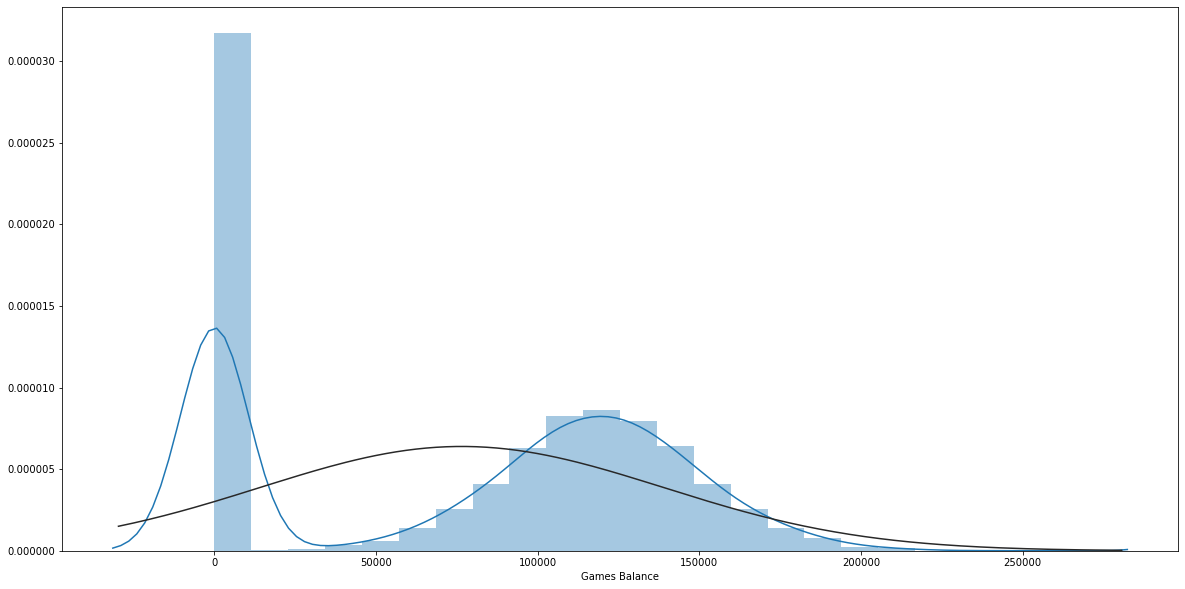

In [39]:
# Plot the distribution
plt.figure(figsize= [20.0, 10.0])
sns.distplot(dataset['Games Balance'], fit=norm)

In [40]:
# We decide to bin that variable, first check basic stats
dataset['Games Balance'].describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Games Balance, dtype: float64

In [46]:
pd.cut(dataset['Games Balance'], bins=4).value_counts()

(-250.898, 62724.522]       3813
(62724.522, 125449.045]     3493
(125449.045, 188173.568]    2612
(188173.568, 250898.09]       82
Name: Games Balance, dtype: int64

In [47]:
dataset['GamesBalanceGroup'] = pd.cut(dataset['Games Balance'], 4, 
                                      labels=['LOW', 'MEDIUM', 'INTERMEDIATE', 'HIGH'])

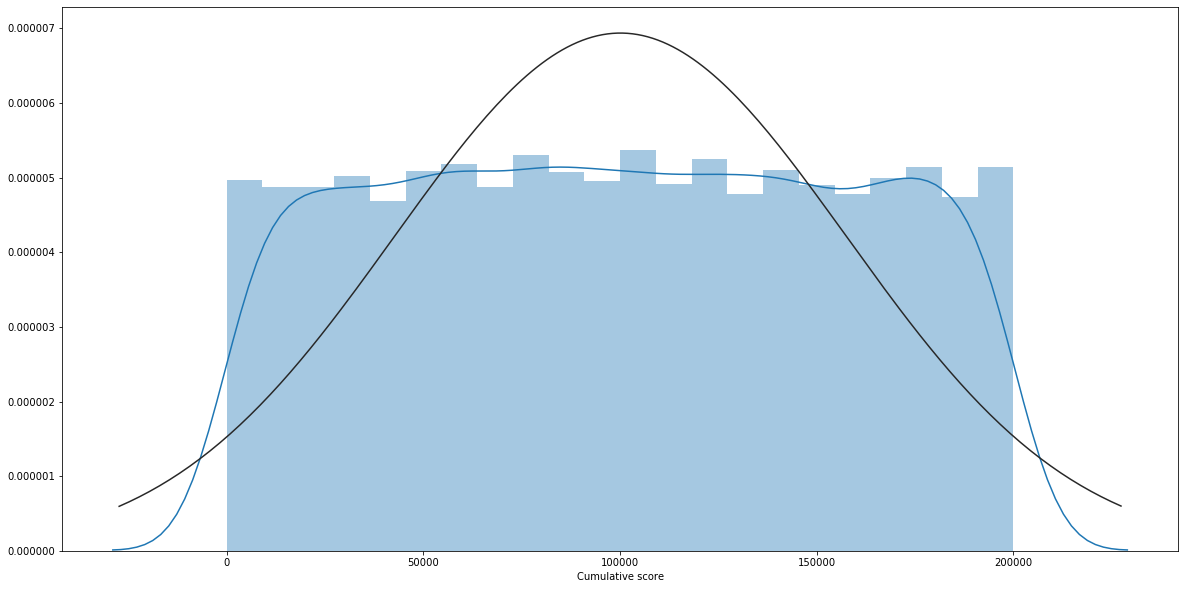

In [49]:
# Plot the distribution
plt.figure(figsize= [20.0, 10.0])
sns.distplot(dataset['Cumulative score'], fit=norm)

In [50]:
# We decide to bin that variable, first check basic stats
dataset['Cumulative score'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: Cumulative score, dtype: float64

In [53]:
print("Cumulative score variable has {0} total observations and {1} are unique only.".format(dataset['Cumulative score'].count(),dataset['Cumulative score'].nunique()))

Cumulative score variable has 10000 total observations and 9999 are unique only.


In [55]:
# We can choose for equal intervals, example 4 bins
pd.qcut(dataset['Cumulative score'], q=6)

0       (100193.915, 132801.57]
1       (100193.915, 132801.57]
2       (100193.915, 132801.57]
3        (67057.27, 100193.915]
4        (67057.27, 100193.915]
                 ...           
9995     (67057.27, 100193.915]
9996    (100193.915, 132801.57]
9997      (34025.025, 67057.27]
9998     (67057.27, 100193.915]
9999      (34025.025, 67057.27]
Name: Cumulative score, Length: 10000, dtype: category
Categories (6, interval[float64]): [(11.579, 34025.025] < (34025.025, 67057.27] < (67057.27, 100193.915] < (100193.915, 132801.57] < (132801.57, 166912.72] < (166912.72, 199992.48]]

In [56]:
dataset['CumScoreGroup'] = pd.qcut(dataset['Cumulative score'], 8, labels=['Entry-Level', 'Rookie', 'Novice', 'Intermediate', 'Expert', 'Master', 'GrandMaster', 'Commodoro'])

In [57]:
# Check the results
pd.crosstab(dataset['CumScoreGroup'], dataset['Churn'],
           margins=True)

Churn             0     1    All
CumScoreGroup                   
Entry-Level    1003   247   1250
Rookie          997   253   1250
Novice          989   261   1250
Intermediate   1016   234   1250
Expert          998   252   1250
Master          999   251   1250
GrandMaster     981   269   1250
Commodoro       980   270   1250
All            7963  2037  10000

# First conclusion

After checked with the EDA - Exploratory Data Analysis, we have first most important insights to show:

- The dataset is a sample with `10k` values, we haven't null values
- In this first instance we be able to prepare and manipulate dataset for to make a good model, maybe they are few data to receive a good `accuracy score` 
- There are `7963` customers are churned and 2037 aren't. That is a 79%.
- Customer come from three main countries, one of them has high churn rate, `Germany` with almost 32%
- For age's group we have high churn rate from two profiles: `Mid-Senior`:49,8% and `Adult`: 48,1%
- The 14% churned customer was an `active member`, but 27% wasn't.
- The 70% churned customer was a `Premium access`

In [58]:
dataset.head(10)

idClient  Score CountryLocation  Gender  Age  Tenure  Games Balance  \
0         1    619          France       1   42       2           0.00   
1         2    608           Spain       1   41       1       83807.86   
2         3    502          France       1   42       8      159660.80   
3         4    699          France       1   39       1           0.00   
4         5    850           Spain       1   43       2      125510.82   
5         6    645           Spain       0   44       8      113755.78   
6         7    822          France       0   50       7           0.00   
7         8    376         Germany       1   29       4      115046.74   
8         9    501          France       0   44       4      142051.07   
9        10    684          France       0   27       2      134603.88   

   NumOfProducts  HasPremiumAccess  IsActiveMember  Cumulative score  Churn  \
0              1                 1               1         101348.88      1   
1              1                 0               1         112542.58      0   
2              3                 1               0         113931.57      1   
3              2                 0               0          93826.63      0   
4              1                 1               1          79084.10      0   
5              2                 1               0         149756.71      1   
6              2                 1               1          10062.80      0   
7              4                 1               0         119346.88      1   
8              2                 0               1          74940.50      0   
9              1                 1               1          71725.73      0   

  ScoreGroup     AgeGroup GamesBalanceGroup CumScoreGroup  
0       GOLD  Young Adult               LOW        Expert  
1       GOLD  Young Adult            MEDIUM        Expert  
2     SILVER  Young Adult      INTERMEDIATE        Expert  
3       GOLD  Young Adult               LOW  Intermediate  
4   PLATINUM  Young Adult      INTERMEDIATE  Intermediate  
5       GOLD  Young Adult            MEDIUM   GrandMaster  
6   PLATINUM        Adult               LOW   Entry-Level  
7     BRONCE      Student            MEDIUM        Expert  
8     SILVER  Young Adult      INTERMEDIATE        Novice  
9       GOLD      Student      INTERMEDIATE        Novice

In [59]:
# Guardamos el resultado en nuevo dataset
dataset.to_csv('df1_eda.csv', index=False)